In [1]:
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# Read the file
dat = h5py.File('double_dot(n).h5', 'r')

print(dat.keys())
print(dat['dataset'].keys())

# Load the dataset
X = np.array(dat['dataset']['voltages'])
y = np.array(dat['dataset']['gates_w'])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

<KeysViewHDF5 ['V1', 'V2', 'dataset', 'noise']>
<KeysViewHDF5 ['gates_w', 'voltages']>


NameError: name 'ticker' is not defined

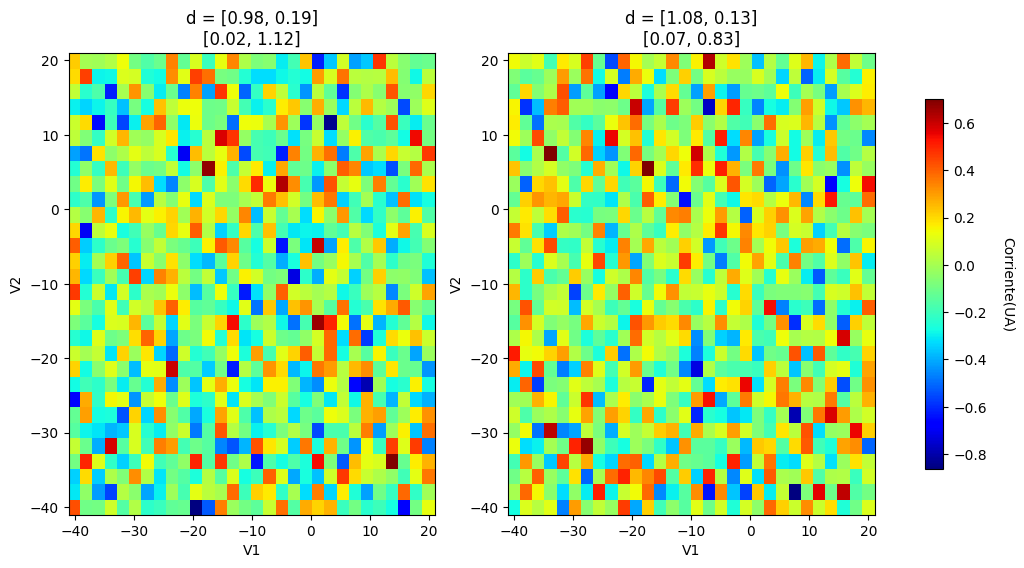

In [5]:
# Data visualization
import matplotlib.pyplot as plt

x = dat['V1']
y = dat['V2']
X, Y = np.meshgrid(x, y)

current1 = np.array(dat['noise'][0])
#current1 = np.array(dat['dataset']['voltages'][0])
d1 = np.array(dat['dataset']['gates_w'][0]).reshape(2,2)

current2 = np.array(dat['noise'][1])
#current2 = np.array(dat['dataset']['voltages'][1])
d2 = np.array(dat['dataset']['gates_w'][1]).reshape(2,2)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

# Plot the first image
img1 = ax1.pcolor(X, Y, current1, vmax=np.max(current1), cmap='jet')
ax1.set_xlabel('V1')
ax1.set_ylabel('V2')
formatted_d = [['{:.2f}'.format(x) for x in row] for row in d1]
legend_text = 'd = ' + '\n'.join(['[' + ', '.join(row) + ']' for row in formatted_d])
ax1.set_title(legend_text)
#cbar = fig.colorbar(img1, ax=ax1, shrink=0.8)
#cbar.set_label('Corriente(UA)', rotation=270, labelpad=20)
#cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
#cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))

# Plot the second image
img2 = ax2.pcolor(X, Y, current2, vmax=np.max(current1), cmap='jet')
ax2.set_xlabel('V1')
ax2.set_ylabel('V2')
formatted_d = [['{:.2f}'.format(x) for x in row] for row in d2]
legend_text = 'd = ' + '\n'.join(['[' + ', '.join(row) + ']' for row in formatted_d])
ax2.set_title(legend_text)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2)

cbar = fig.colorbar(img2, ax=(ax1,ax2), shrink=0.8)
cbar.set_label('Corriente(UA)', rotation=270, labelpad=20)
cbar.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))

# Adjust the position of the colorbar
pos = ax2.get_position()
cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])

#plt.tight_layout()  # Adjust spacing between subplots
plt.savefig('data_vis')

In [4]:
# Convert data to tensors
# The extra dimension is for a correct interpretation by the DataLoader
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create a custom dataset
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

# Data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [36]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Define your model architecture
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 30 * 30, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        # Implement the forward pass
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.relu3(out)
        out = self.fc2(out)
        return out
    
model = CNNModel()

# Define the training loop
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(model, data_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    for inputs, targets in data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    return train_loss / len(data_loader.dataset)

In [38]:
# Train the model
num_epochs = 10
train_loss = np.ones(num_epochs)
test_loss_CNN1 = np.ones(num_epochs)
for epoch in range(num_epochs):
    train_loss[epoch] = train(model, train_loader, optimizer, criterion)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[epoch]:.4f}")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
        test_loss /= len(test_loader.dataset)
    test_loss_CNN1[epoch] = test_loss

    print(f"Test Loss: {test_loss:.4f}")

Epoch 1/10, Train Loss: 0.0072
Test Loss: 0.0071
Epoch 2/10, Train Loss: 0.0073
Test Loss: 0.0068
Epoch 3/10, Train Loss: 0.0074
Test Loss: 0.0072
Epoch 4/10, Train Loss: 0.0073
Test Loss: 0.0071
Epoch 5/10, Train Loss: 0.0072
Test Loss: 0.0069
Epoch 6/10, Train Loss: 0.0073
Test Loss: 0.0072
Epoch 7/10, Train Loss: 0.0072
Test Loss: 0.0072
Epoch 8/10, Train Loss: 0.0073
Test Loss: 0.0075
Epoch 9/10, Train Loss: 0.0075
Test Loss: 0.0074
Epoch 10/10, Train Loss: 0.0073
Test Loss: 0.0067


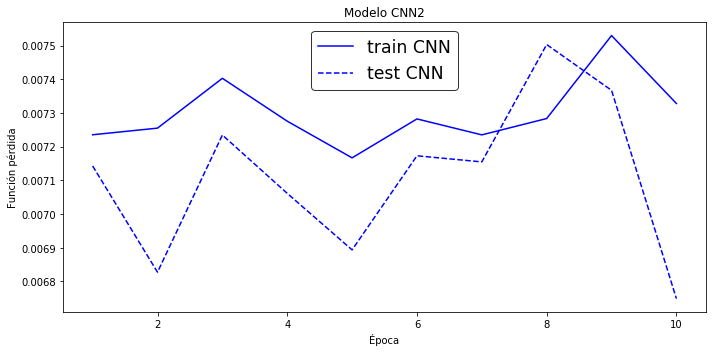

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10.0, 5.0)
colors = plt.cm.Dark2.colors

ax.set_xlabel("Época")
ax.set_ylabel("Función pérdida")
ax.set_title("Modelo CNN2")
ax.plot(range(1, len(train_loss) + 1), train_loss, label="train CNN", linestyle='-', c='b')
ax.plot(range(1, len(test_loss_CNN1) + 1), test_loss_CNN1, label="test CNN", linestyle='--', c='b')
legend = ax.legend(fontsize='xx-large')
legend.get_frame().set_edgecolor('black')

fig.tight_layout()
plt.savefig('2')

In [29]:
print(model(X_train[564].unsqueeze(1)))
print(y_train[564])

tensor([[1.0184, 0.0484, 0.0854, 1.0050]], grad_fn=<AddmmBackward0>)
tensor([0.9012, 0.0318, 0.0040, 1.0453])
